In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

           symbol       close       volume
date                                      
2010-01-04   AAPL  214.009998  123432400.0
2010-01-04    ABT   54.459951   10829000.0
2010-01-04    AIG   29.889999    7750900.0
2010-01-04   AMAT   14.300000   18615100.0
2010-01-04   ARNC   16.650013   11512100.0


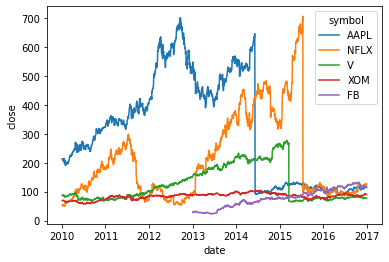

In [14]:
# Read in the data
data = pd.read_csv('https://assets.datacamp.com/production/repositories/1536/datasets/43d325fa67cde1d4d5de62adc108fceabaddf3cc/prices.csv', index_col=0)

# Convert the index of the DataFrame to datetime
data.index = pd.to_datetime(data.index)
print(data.head())
#select a few stocks
stocks=['AAPL','FB','NFLX','XOM','V']
best_stocks=data[data.symbol.isin(stocks)]

# Loop through each column, plot its values over time
sns.lineplot(data=best_stocks,x='date',y='close',hue='symbol')
plt.show()

In [15]:
ebay_values=data[data['symbol']=='EBAY']
ebay_values=ebay_values.close
nvda_values=data[data['symbol']=='NVDA']
nvda_values=nvda_values.close
yhoo_values=data[data['symbol']=='YHOO']
yhoo_values=yhoo_values.close

prices_merged={'EBAY':ebay_values,'NVDA':nvda_values,'YHOO':yhoo_values}
X=pd.DataFrame(data=prices_merged)

aapl_values=data[data['symbol']=='AAPL']
y=aapl_values.close
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score


# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X,y, cv=5)
print(scores)

[-3.79519169e+00  6.88754904e-02 -9.39666910e+00 -1.71517506e+00
 -3.28621454e+03]


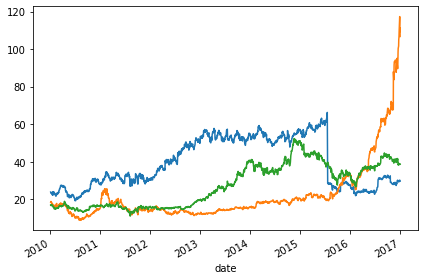

EBAY    0
NVDA    0
YHOO    0
dtype: int64


In [16]:

prices=X

# Visualize the dataset
prices.plot(legend=False)
plt.tight_layout()
plt.show()

# Count the missing values of each time series
missing_values = prices.isna().sum()
print(missing_values)

## en caso de tener valores perdidos, hacer lo siguiente


In [17]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

## no pasara nada con los graficos pq no hay valores perdidos 

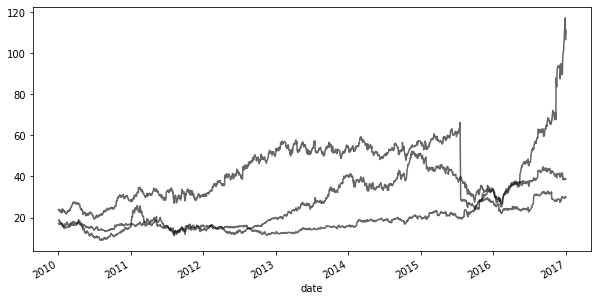

In [18]:
# Interpolate using the latest non-missing value
interpolation_type = 'zero'
interpolate_and_plot(prices, interpolation_type)

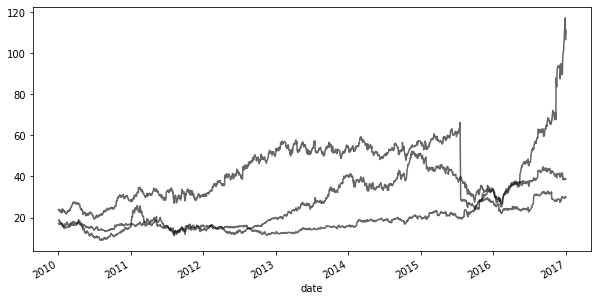

In [19]:
# Interpolate linearly
interpolation_type = 'linear'
interpolate_and_plot(prices, interpolation_type)

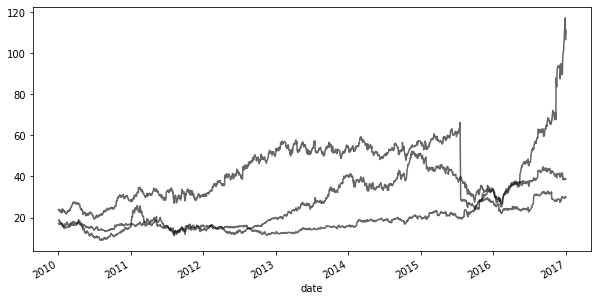

In [20]:
# Interpolate with a quadratic function
interpolation_type = 'quadratic'
interpolate_and_plot(prices, interpolation_type)

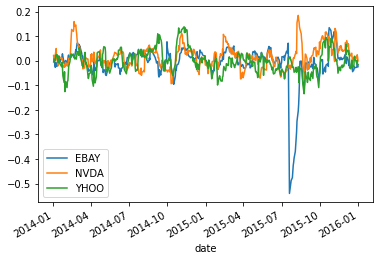

In [21]:
# Your custom function
def percent_change(values):
    # Collect all *but* the last value of this window, then the final value
    previous_values = values[:-1]
    last_value = values[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

What happened to EBAY in 2015? 

Ebay used to own PayPal, but the two business were splited in the hopes that they will be able to operate better separately. Hence the ~50% loss of value in Ebay. If you owned Ebay shares, you should be receiving the same number PayPal shares.

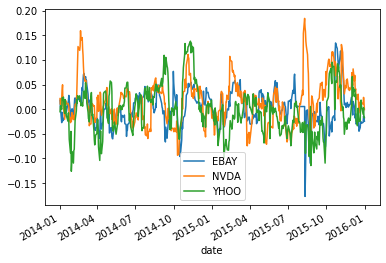

In [22]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot()
plt.show()

# arreglar X e y

In [23]:
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import r2_score

# Split our data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.8, shuffle=False, random_state=1)
# Fit our model and generate predictions
#model = Ridge()
#model.fit(X_train,y_train)
#predictions = model.predict(X_test)
#score = r2_score(y_test, predictions)
#print(score)

# Visualize our predictions along with the "true" values, and print the score
#fig, ax = plt.subplots(figsize=(15, 5))
#ax.plot(y_test, color='k', lw=3)
#ax.plot(predictions, color='r', lw=2)
#plt.show()

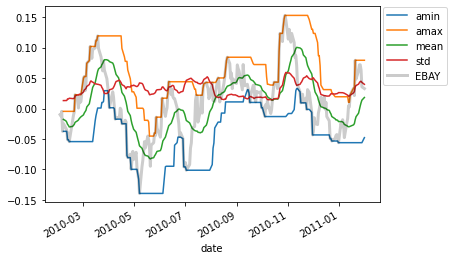

In [26]:
prices_perc_ebay=prices_perc['EBAY']

# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc_ebay.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc_ebay.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

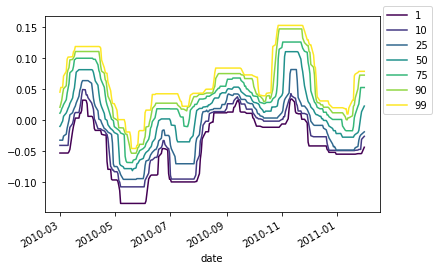

In [28]:
# Import partial from functools
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc_ebay.rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

In [31]:
# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.weekday
prices_perc['week_of_year'] = prices_perc.index.week
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
print(prices_perc)

                EBAY      NVDA      YHOO  day_of_week  week_of_year  \
date                                                                  
2010-01-04       NaN       NaN       NaN            0             1   
2010-01-05       NaN       NaN       NaN            1             1   
2010-01-06       NaN       NaN       NaN            2             1   
2010-01-07       NaN       NaN       NaN            3             1   
2010-01-08       NaN       NaN       NaN            4             1   
...              ...       ...       ...          ...           ...   
2016-12-23  0.024842  0.147720 -0.038006            4            51   
2016-12-27  0.038030  0.008406 -0.027985            1            52   
2016-12-28  0.026925  0.117737 -0.029311            2            52   
2016-12-29  0.021850  0.129669 -0.028632            3            52   
2016-12-30  0.007285  0.068559 -0.026603            4            52   

            month_of_year  
date                       
2010-01-04          

In this exercise, you'll "shift" your raw data and visualize the results. You'll use the percent change time series that you calculated in the previous chapter, this time with a very short window. A short window is important because, in a real-world scenario, you want to predict the day-to-day fluctuations of a time series, not its change over a longer window of time.

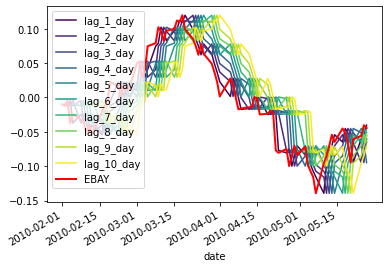

In [32]:

# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc_ebay.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc_ebay.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

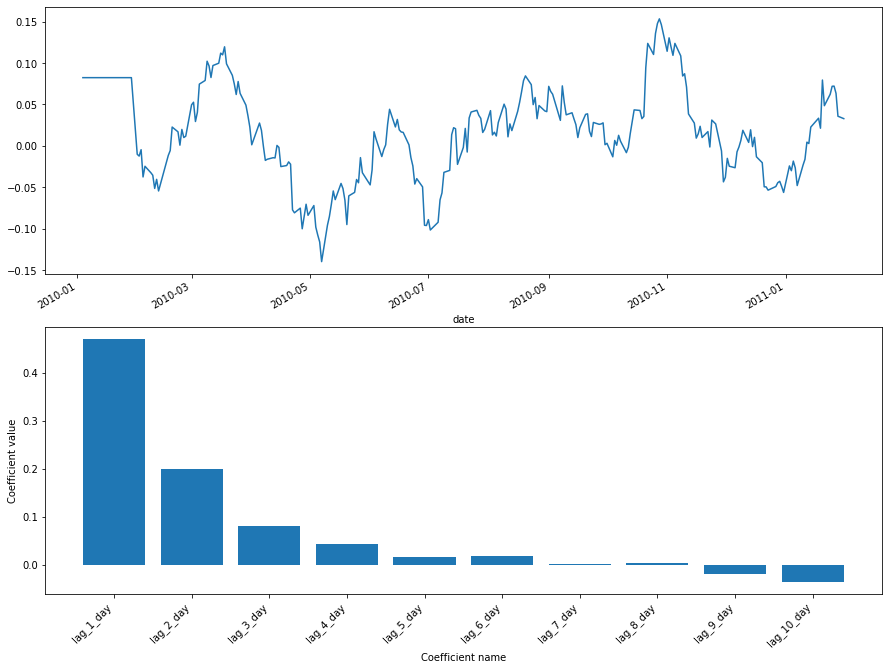

In [38]:
# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc_ebay.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X,y)

def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names,coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(15, 12))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

## As you can see here, by transforming your data with a larger window, you've also changed the relationship between each timepoint and the ones that come just before it. This model's coefficients gradually go down to zero, which means that the signal itself is smoother over time. Be careful when you see something like this, as it means your data is not i.i.d.